## Model (Clustering or Association Rules)

* Team : Data Crew

(Clustering for the customers or finding patterns in the data with some association rulel algorithms)

* Libraries required

In [28]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librarie for Preprocessing
from utils import *

# Data Structures
from collections import defaultdict

# Model Libraries
from xgboost import XGBClassifier

# Import torch
import torch
import torch.nn as nn

# Model Selection and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold

sns.set_style('whitegrid')

* Retrieving the data from the original source

In [29]:
data = pd.read_csv('../../1. Data/smaller_sample.csv')
event_defs = pd.read_csv('../../1. Data/Event+Definitions.csv')

* Data Cleaning and Feature Engineering

In [30]:
df = get_classification_dataset(data, event_defs, n_events=5)
df

,,num_journeys,max_journey,discover,approved_credit,first_purchase,account_activitation,downpayment_received,downpayment_cleared,order_ships,max_milestone,number_accounts,one_more_journey,most_repeated_event,average_length_seq,first_5_events
customer_id,,,,,,,,,,,,,,,,
5414,0,1,27,True,True,False,False,False,False,False,1.0,1,False,4,24.0,"[21, 12, 4, 2, 4]"
26746,0,1,5,True,True,False,False,False,False,False,1.0,1,False,2,3.0,"[2, 12, 21]"
43085,0,1,30,True,True,True,True,True,True,True,6.0,1,False,5,30.0,"[29, 2, 12, 4, 4]"
61659,0,1,7,True,True,False,False,False,False,False,1.0,1,False,4,7.0,"[12, 23, 4, 11, 6]"
67034,0,1,22,True,True,False,False,False,False,False,1.0,1,False,19,17.0,"[2, 19, 19, 19, 19]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147283220,0,1,12,True,True,False,False,False,False,False,1.0,1,False,4,11.0,"[12, 4, 4, 4, 4]"
2147340717,0,1,11,False,True,False,False,False,False,False,1.0,1,False,21,8.0,"[12, 24, 4, 11, 5]"
2147417277,0,1,15,False,True,False,False,False,False,False,1.0,1,False,3,13.0,"[12, 6, 11, 5, 4]"


### Selecting the customers with a certain amount of events

In [31]:
number_events_fixed = 5

lengths = df['first_5_events'].apply(lambda x: len(x))
print(lengths.value_counts())

first_5_events
5    70432
3     3765
4     3584
2     3335
1     2166
Name: count, dtype: int64


In [32]:
idxs = lengths[lengths == number_events_fixed].index
df_selected = df.loc[idxs]

### New dataset without the following columns:

* First 5 events
* max_milestone

In [36]:
df_prueba = df_selected.drop(columns=['max_milestone', 'downpayment_cleared', 'first_purchase', 'downpayment_received', 'account_activitation'])
df_prueba

,,num_journeys,max_journey,discover,approved_credit,order_ships,number_accounts,one_more_journey,most_repeated_event,average_length_seq,first_5_events
customer_id,,,,,,,,,,,
5414,0,1,27,True,True,False,1,False,4,24.0,"[21, 12, 4, 2, 4]"
43085,0,1,30,True,True,True,1,False,5,30.0,"[29, 2, 12, 4, 4]"
61659,0,1,7,True,True,False,1,False,4,7.0,"[12, 23, 4, 11, 6]"
67034,0,1,22,True,True,False,1,False,19,17.0,"[2, 19, 19, 19, 19]"
102485,0,1,114,False,True,False,1,False,4,107.0,"[19, 19, 19, 19, 19]"
...,...,...,...,...,...,...,...,...,...,...,...
2147283220,0,1,12,True,True,False,1,False,4,11.0,"[12, 4, 4, 4, 4]"
2147340717,0,1,11,False,True,False,1,False,21,8.0,"[12, 24, 4, 11, 5]"
2147417277,0,1,15,False,True,False,1,False,3,13.0,"[12, 6, 11, 5, 4]"


### Change type of the column with the sequences

As this column contains arrays of the fixed specified length, we cannot parse it directly to our model.

In [37]:
class Embedding(nn.Module):
    def __init__(self, embedding_dim, n_events=5):
        super().__init__()
        self.fc1 = nn.Linear(n_events, embedding_dim, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [38]:
# Embed event id sequence into smaller dimension
event_id = df_prueba.first_5_events
event_id = torch.tensor(event_id.to_list()).float()
emb = Embedding(5, 5)
event_id = emb(event_id)

In [39]:
event_id_df = pd.DataFrame(event_id.detach().numpy())
ori_dfx = df_prueba.drop(columns='first_5_events').reset_index(drop=True)
new_dfx = pd.concat([ori_dfx, event_id_df], axis=1)
new_dfx

,num_journeys,max_journey,discover,approved_credit,order_ships,number_accounts,one_more_journey,most_repeated_event,average_length_seq,0,1,2,3,4
0,1,27,True,True,False,1,False,4,24.0,1.938016,-3.480770,-1.872133,2.131491,-1.392137
1,1,30,True,True,True,1,False,5,30.0,1.900735,-4.595749,-0.390504,1.526186,-2.635365
2,1,7,True,True,False,1,False,4,7.0,4.762094,-2.239692,-2.513132,4.207932,-1.156086
3,1,22,True,True,False,1,False,19,17.0,5.004803,-0.988361,-1.820953,3.740535,-0.917466
4,1,114,False,True,False,1,False,4,107.0,3.337406,-3.976526,-1.961078,3.214496,-2.211823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70427,1,12,True,True,False,1,False,4,11.0,0.446062,-2.034497,-0.609596,0.642894,-0.969711
70428,1,11,False,True,False,1,False,21,8.0,5.152497,-2.304863,-2.640131,4.525086,-1.244394
70429,1,15,False,True,False,1,False,3,13.0,1.492532,-2.871199,-0.859833,1.535089,-1.723021
70430,1,32,False,True,False,1,False,4,27.0,0.702612,-0.837163,-0.412858,0.676736,-0.465647


### Separating the data and the target

In this case we want the target to be **order_ships** as this is how we are defining a customer journey as successful or not.

In [40]:
df_final = new_dfx

In [41]:
y = df_final['order_ships'].to_numpy()
X = df_final.drop(columns=['order_ships']).to_numpy()

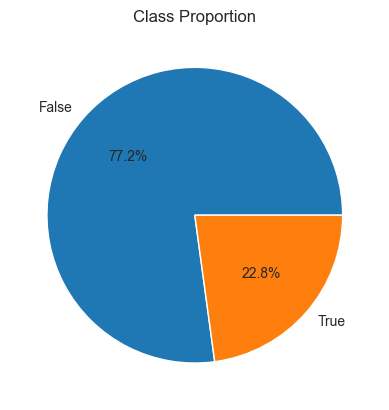

In [42]:
plt.pie(df_final['order_ships'].value_counts(), labels=df_final['order_ships'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Proportion')
plt.show()

## XGBoost (First-Attempt Model)

### Simple Train-Test Split

In [43]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)

# Train the model
xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, n_jobs=-1, random_state=2024)
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
print('Metrics : ')
print(classification_report(y_test, y_pred))

Metrics : 
              precision    recall  f1-score   support

       False       0.85      0.93      0.89     16357
        True       0.65      0.43      0.52      4773

    accuracy                           0.82     21130
   macro avg       0.75      0.68      0.70     21130
weighted avg       0.80      0.82      0.80     21130



<Axes: >

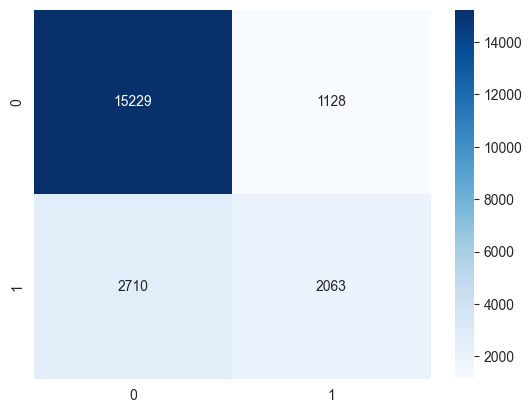

In [44]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

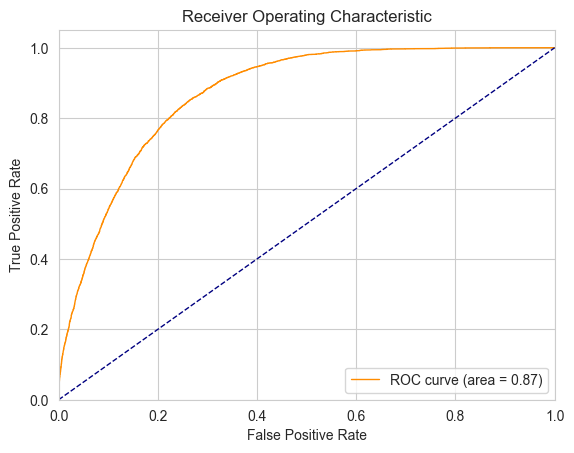

In [45]:
# roc curve
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Cross Validation

In [48]:
# Model
xgb = XGBClassifier(n_estimators=500,
                    learning_rate=0.05,
                    n_jobs=-1,
                    random_state=2024)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
scores = cross_val_score(xgb, X, y, cv=cv, scoring='f1')

print('Mean F1 score : ', scores.mean())
print('Std F1 : ', scores.std())

Mean F1 score :  0.5244846500524195
Std F1 :  0.012230305255622072


### Most Important Features

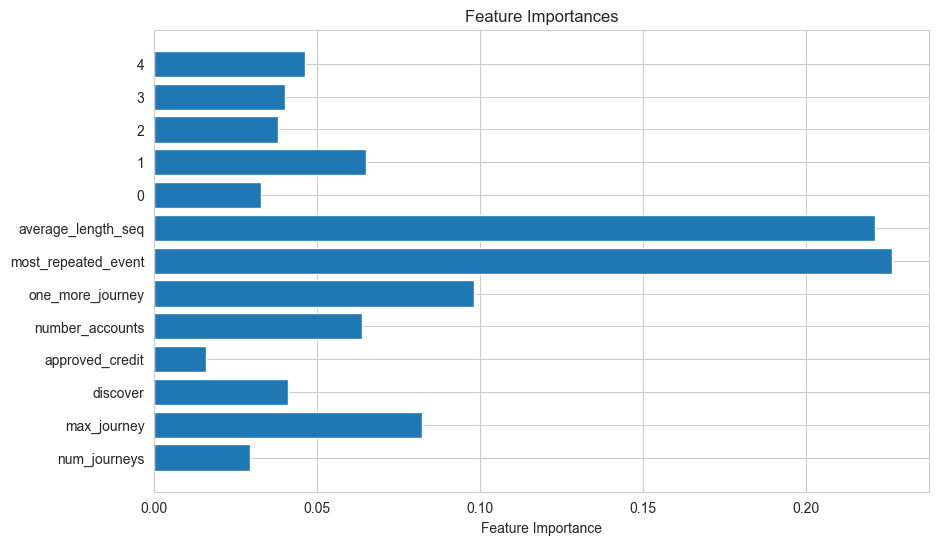

In [49]:
# Train the model
xgb = XGBClassifier(n_estimators=500,
                    learning_rate=0.05,
                    n_jobs=-1,
                    random_state=2024)
xgb.fit(X,y)

# Columns
x = list(df_final.drop(columns=['order_ships']).columns)
x = [str(x_i) for x_i in x]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(x, xgb.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()